<a href="https://colab.research.google.com/github/tomektom10/dataScienceBootCamp/blob/main/model_lstm_energia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [20]:
import pandas as pd
import pandas as pd
import numpy as np
df = pd.read_excel("PROGNOZY + dane_na_model.xlsx")

In [21]:
df

,Datetime,Unnamed: 1,SK Backcast,SK Residual Load Backcast,SK Residual Production Backcast,SK Exchange Day-Ahead Schedule Net Export MWh/h H Backcast,SK Consumption MWh/h 15min Backcast,SK Nuclear Production MWh/h 15min Backcast,SK Solar Photovoltaic Production MWh/h 15min Backcast,HU>SK Exchange Day-Ahead Schedule MWh/h H Backcast,PL>SK Exchange Day-Ahead Schedule MWh/h H Backcast,SK>HU Exchange Day-Ahead Schedule MWh/h H Backcast,SK>PL Exchange Day-Ahead Schedule MWh/h H Backcast,CZ>SK Exchange Day-Ahead Schedule MWh/h H Backcast,SK>CZ Exchange Day-Ahead Schedule MWh/h H Backcast,Bilans,Weighted average price of all trades (EUR/MWh),Minimal price (EUR/MWh),Maximal price (EUR/MWh),Price SK (EUR/MWh)
0,2023-01-01 00:00:00,1,1.47,2259.6,323.9,-1.3,2259.6,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1301.5,-1301.5,-5.00000,18.93,7.00,30.26,20.26
1,2023-01-01 01:00:00,2,-1.24,2221.9,346.4,58.5,2221.9,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1241.7,-1241.7,-4.99750,1.35,0.30,10.33,0.33
2,2023-01-01 02:00:00,3,-1.69,2164.5,129.3,-98.9,2164.5,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1399.2,-1399.2,-5.00000,2.05,0.50,10.50,0.50
3,2023-01-01 03:00:00,4,-3.52,2086.6,175.5,24.1,2086.6,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1276.2,-1276.2,-5.00000,2.26,0.00,10.50,0.50
4,2023-01-01 04:00:00,5,-3.14,2074.1,211.7,71.7,2074.1,1940.0,0.0,-1300.0,-0.3,1300.0,0.3,1228.6,-1228.6,-5.00000,3.12,0.00,10.10,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13865,2024-07-31 19:00:00,20,126.10,2884.8,1375.8,391.1,2903.9,1940.0,19.1,0.0,-1500.0,0.0,1500.0,1308.9,-1308.9,307.98750,170.96,124.01,194.00,94.80
13866,2024-07-31 20:00:00,21,161.32,2937.5,1361.0,330.8,2938.2,1940.0,0.8,0.0,-1500.0,0.0,1500.0,1369.2,-1369.2,133.26250,158.80,150.00,167.79,173.31
13867,2024-07-31 21:00:00,22,116.30,2860.2,1448.5,506.9,2860.2,1940.0,0.0,0.0,-1500.0,0.0,1500.0,1193.1,-1193.1,251.44005,177.99,130.51,202.93,97.29
13868,2024-07-31 22:00:00,23,102.43,2687.7,1323.4,534.4,2687.7,1940.0,0.0,0.0,-1500.0,0.0,1500.0,1165.6,-1165.6,400.00875,139.59,80.01,169.31,106.68


In [22]:
futures=['SK Residual Load Backcast', "SK Residual Production Backcast", 'Weighted average price of all trades (EUR/MWh)' ]

In [23]:
df.columns

Index(['Datetime', 'Unnamed: 1', 'SK Backcast', 'SK Residual Load Backcast',
       'SK Residual Production Backcast',
       'SK Exchange Day-Ahead Schedule Net Export MWh/h H Backcast',
       'SK Consumption MWh/h 15min Backcast',
       'SK Nuclear Production MWh/h 15min Backcast',
       'SK Solar Photovoltaic Production MWh/h 15min Backcast',
       'HU>SK Exchange Day-Ahead Schedule MWh/h H Backcast',
       'PL>SK Exchange Day-Ahead Schedule MWh/h H Backcast',
       'SK>HU Exchange Day-Ahead Schedule MWh/h H Backcast',
       'SK>PL Exchange Day-Ahead Schedule MWh/h H Backcast',
       'CZ>SK Exchange Day-Ahead Schedule MWh/h H Backcast',
       'SK>CZ Exchange Day-Ahead Schedule MWh/h H Backcast', 'Bilans',
       'Weighted average price of all trades (EUR/MWh)',
       'Minimal price (EUR/MWh)', 'Maximal price (EUR/MWh)',
       'Price SK (EUR/MWh)'],
      dtype='object')

In [24]:
target = df['Weighted average price of all trades (EUR/MWh)'].values

In [25]:
input = df[[ 'SK Residual Production Backcast', "SK Residual Load Backcast", "Weighted average price of all trades (EUR/MWh)"]].values

In [26]:
scaler = MinMaxScaler()

futures_scaled = scaler.fit_transform(input)




In [30]:
# Create sequences for LSTM
def create_sequences(data, window_size, prediction_size):
    X = []
    y = []
    for i in range(len(data) - window_size - prediction_size + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + prediction_size, -1])  # Predicting only the price
    return np.array(X), np.array(y)

In [28]:
#liczbs godzina na bazie ktorych generujemy predykcje
window_size = 48

prediction_size = 24

In [29]:
X,y = create_sequences (futures_scaled, window_size, prediction_size)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

Shape of X_train: (11039, 48, 3)
Shape of y_train: (11039, 24)


In [10]:
# # Przekształcenie danych do formatu akceptowalnego przez LSTM (próbki, kroki czasowe, cechy)
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# # X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [34]:
# Inicjalizacja modelu LSTM
model = Sequential()

# Dodanie warstwy LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Dodanie kolejnej warstwy LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dodanie warstwy wyjściowej
model.add(Dense(units = prediction_size))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# Wyświetlenie architektury modelu
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 48, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 48, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           1,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,224 (125.88 KB)

 Trainable params: 32,224 (125.88 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Trenowanie modelu LSTM
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
345/345 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0011 - val_loss: 9.6622e-04
Epoch 2/3
345/345 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 0.0010 - val_loss: 9.6154e-04
Epoch 3/3
345/345 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 0.0011 - val_loss: 9.4346e-04


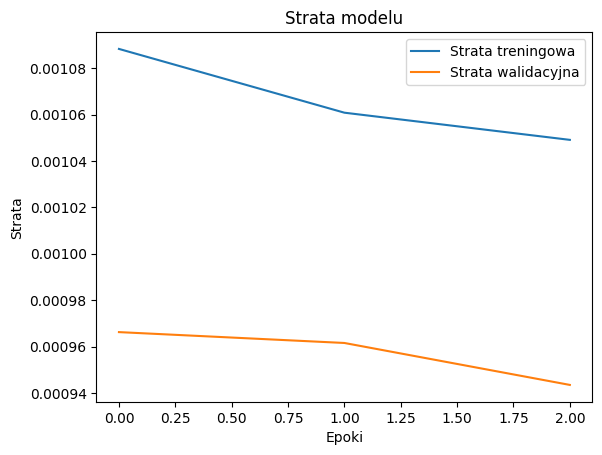

In [38]:
# Wykres strat treningowych i walidacyjnych
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [39]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.3882e-04
Test Loss: 0.0009434559033252299


In [40]:
# Make predictions
predictions = model.predict(X_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [42]:
# y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], 2)), y_test], axis=1))[:, -1]
# predictions_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], 2)), predictions], axis=1))[:, -1]

ValueError: operands could not be broadcast together with shapes (2760,26) (3,) (2760,26) 

In [43]:
# y_test_rescaled = scaler.inverse_transform(y_test)



ValueError: operands could not be broadcast together with shapes (2760,24) (3,) (2760,24) 

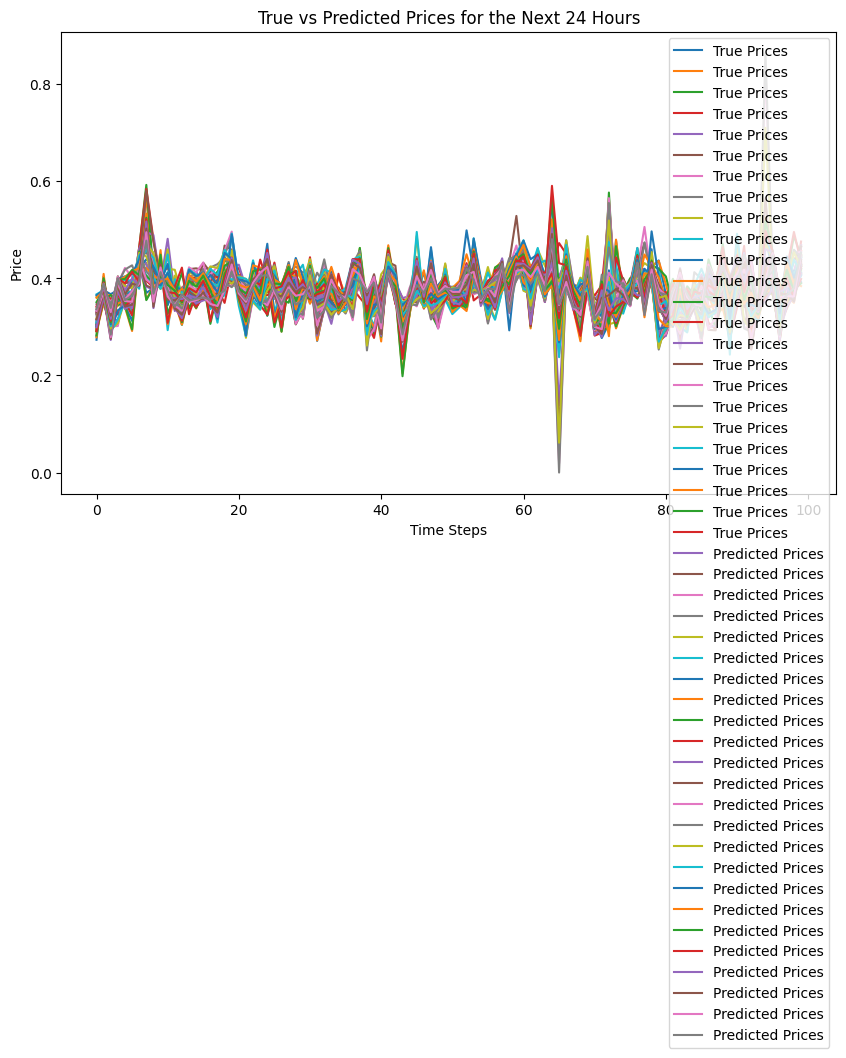

In [45]:
# Plot true vs predicted prices for the next 24 hours
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='True Prices')
plt.plot(predictions[:100], label='Predicted Prices')
plt.title('True vs Predicted Prices for the Next 24 Hours')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

In [46]:
true_24th = y_test[:, -1]        # True values for the 24th hour
predicted_24th = predictions[:, -1]  # Predicted values for the 24th hour

In [47]:
percent_errors = np.abs(true_24th - predicted_24th) / np.abs(true_24th) * 100

In [48]:
sr_blad = np.mean(percent_errors)

In [49]:
sr_blad

6.253730554384811

In [ ]:
##### do zmiany parametrow sieciu moge zmienic size okna, liczbe unit do danych,